# Hungarian Multi Rings

**Goal:** In the past notebooks
- `SA-mini`
- `SA-warm-up`

I've been focusing on a single ring to stay in a good range for the hyperparameters.

**Now:** Really understand what `scipy.optimize.linear_sum_assignment` function is doing.

I think the setup that I had from the earlier notebooks should be ok, but it's just a bit of syntax to follow-up on now :)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

import os
os.sys.path.append('code')

from train import train
from model import SlotAttentionPosEmbed
from data import make_batch
from plotting import plot_kslots, plot_kslots_iters, plot_kslots_grads


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
bs=2
k_slots = 3
n_rings_max = 2
enc_dim = 3

### Modifying Flo's function generation script for new loss function

In [12]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

Let's consider:
- batch_size 4
- 2 rings
- 3 slots

In [13]:
max_n_rings = 2
device='cuda:0'

In [14]:
bs=2
X, Y, true = make_batch(bins, N_events=bs, N_clusters=max_n_rings,device=device)

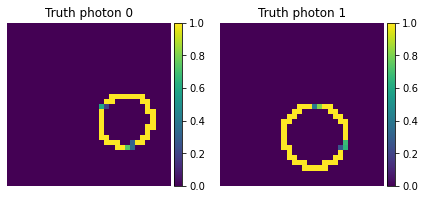

In [15]:
iEvt=1

if max_n_rings>1:
    
    fig, axs = plt.subplots(1,max_n_rings,figsize=(max_n_rings*3+1,3))

    for i,ax in enumerate(axs):

        im = ax.imshow(true[iEvt,i].cpu().numpy(),vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(f'Truth photon {i}')

        ax.axis('off')

    plt.show()

**Define the model**

In [16]:
k_slots=max_n_rings+1
model = SlotAttentionPosEmbed(k_slots=k_slots,device=device).to(device)


Train the model!!

In [20]:
cID = 'rings-bs-256'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

for di in [modelDir,figDir]:
    os.mkdir(di)

Training model with 3 slots on 2rings


/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 0.5874739 , lr 0.0


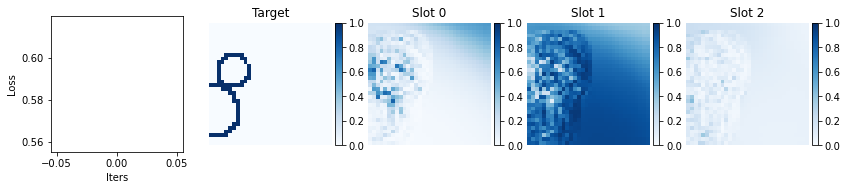

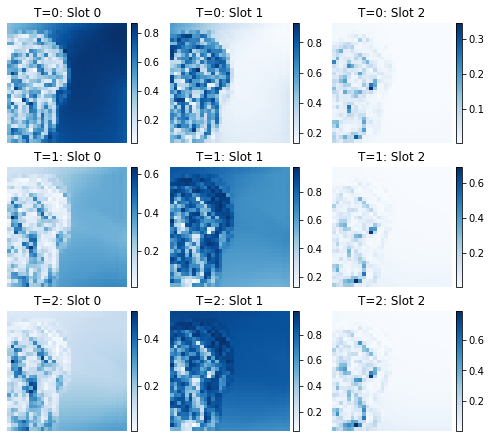

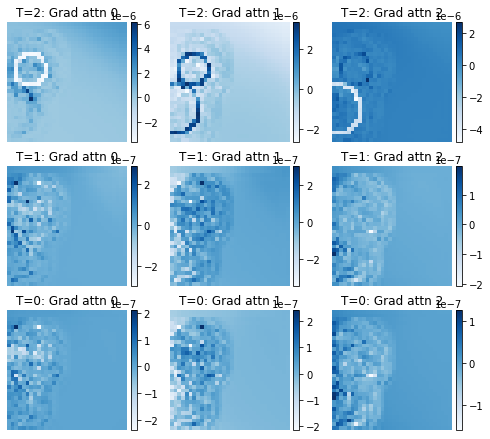

iter 250 , loss 0.4136183 , lr 1.4948103942418015e-05


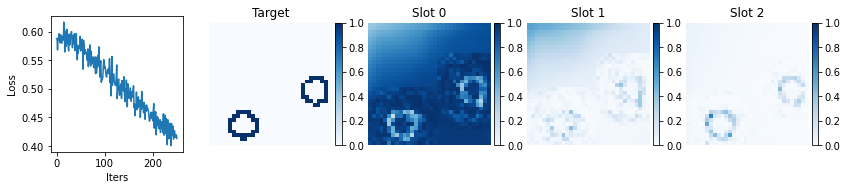

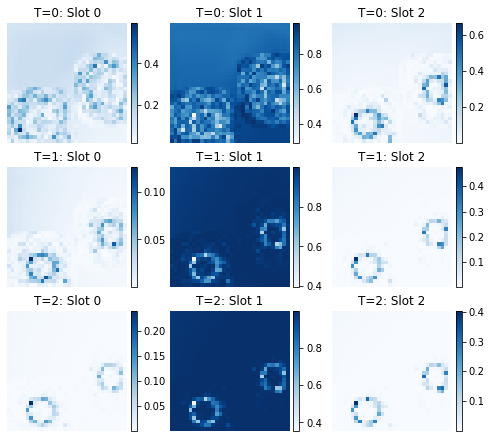

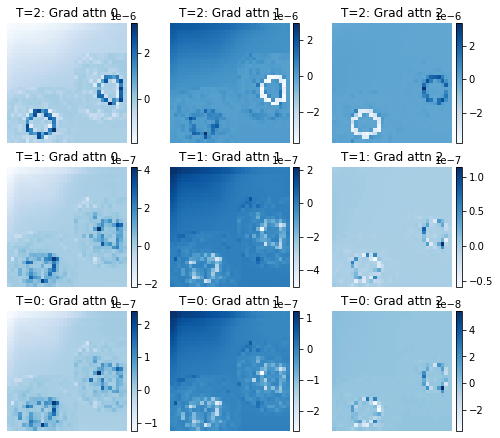

iter 500 , loss 0.20200196 , lr 2.9792774863111075e-05


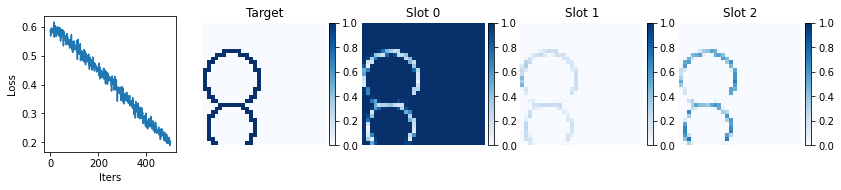

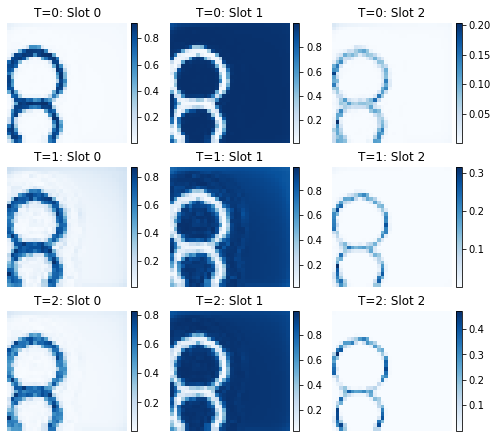

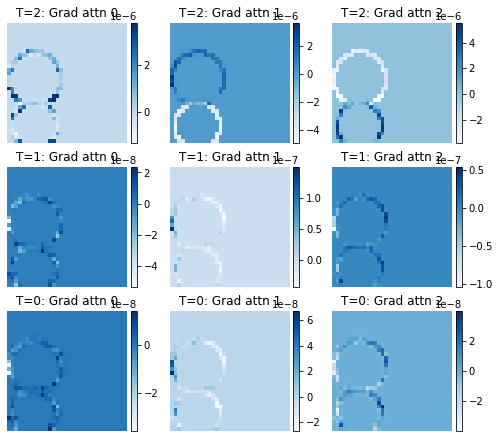

iter 750 , loss 0.13200794 , lr 4.4534549538684304e-05


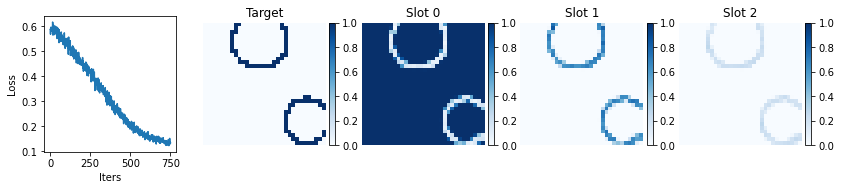

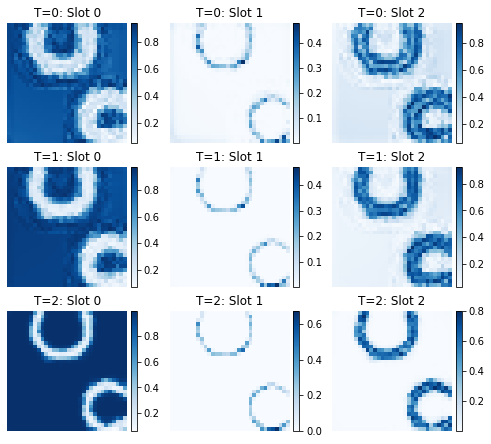

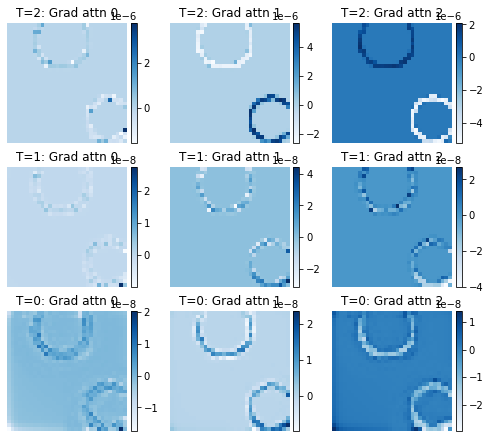

iter 1000 , loss 0.11646137 , lr 5.917396226960155e-05


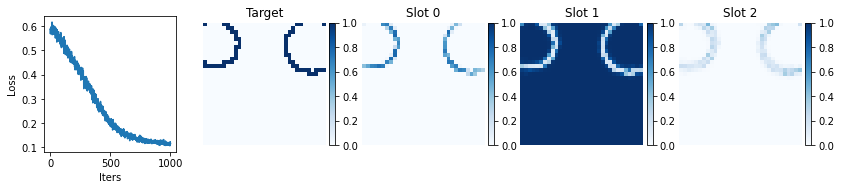

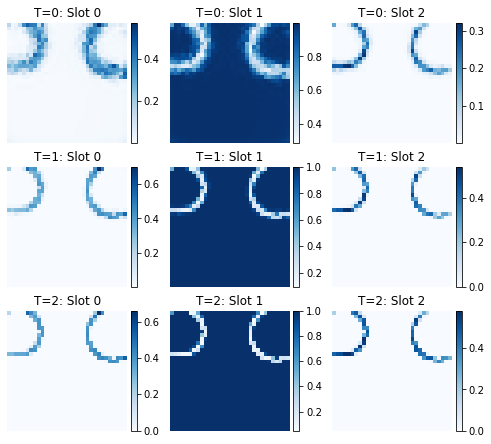

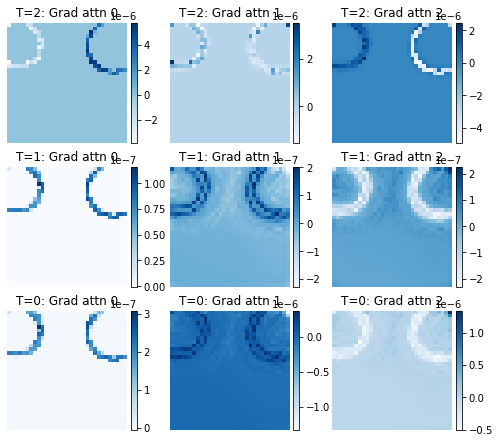

iter 1250 , loss 0.10412355 , lr 7.371154489089383e-05


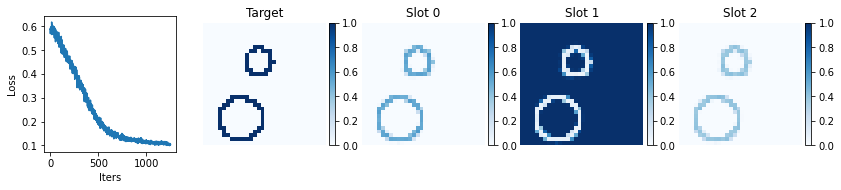

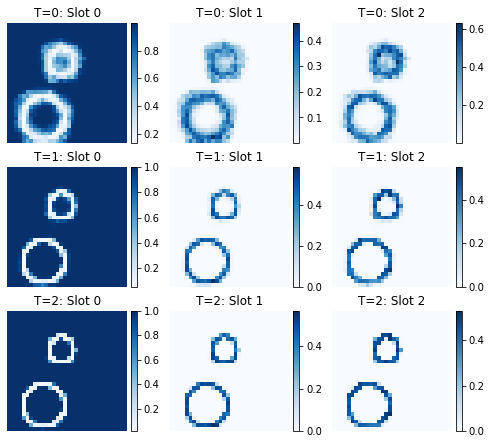

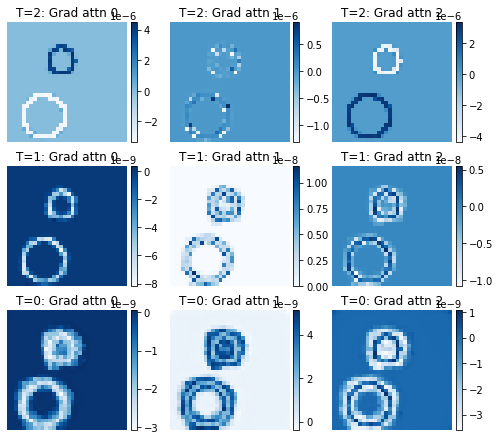

iter 1500 , loss 0.11426781 , lr 8.81478267828234e-05


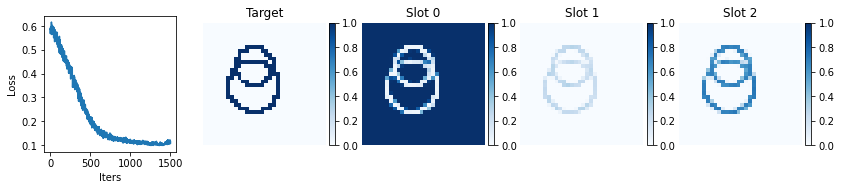

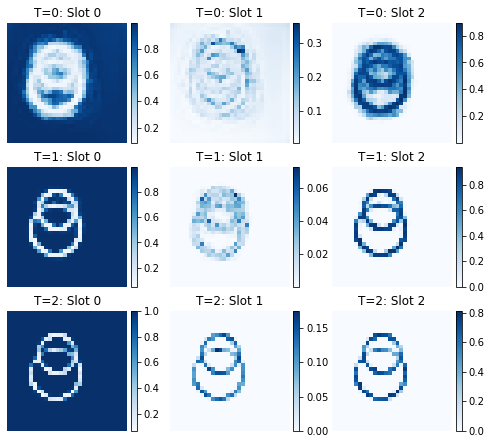

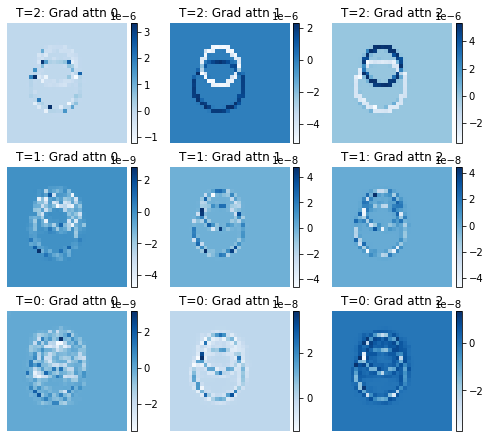

iter 1750 , loss 0.09686839 , lr 0.00010248333488150358


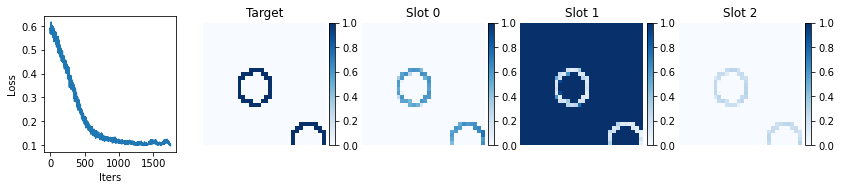

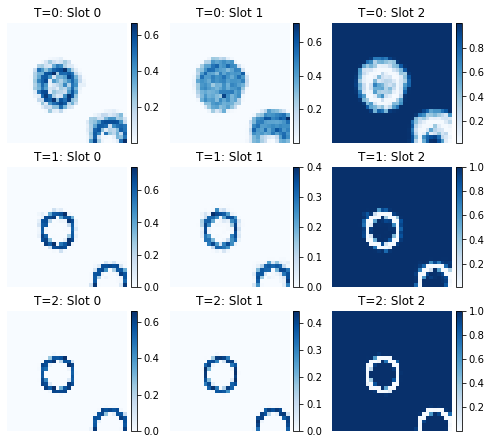

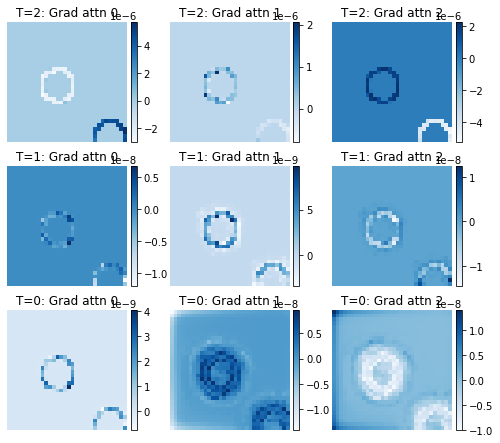

iter 2000 , loss 0.107093886 , lr 0.00011671859368947427


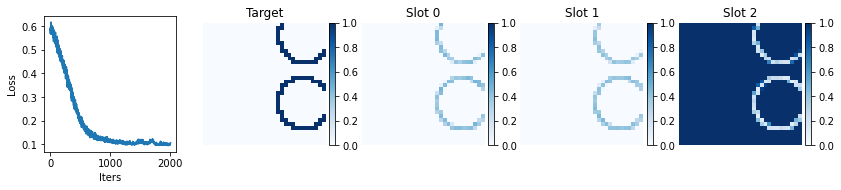

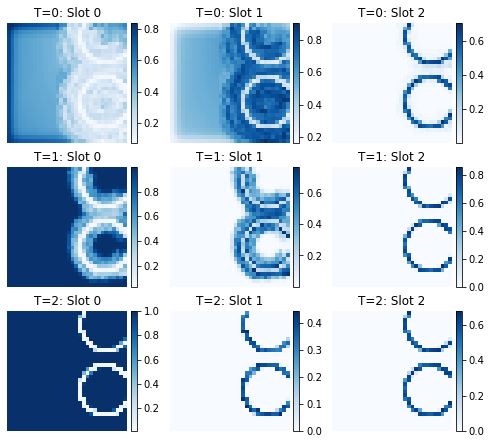

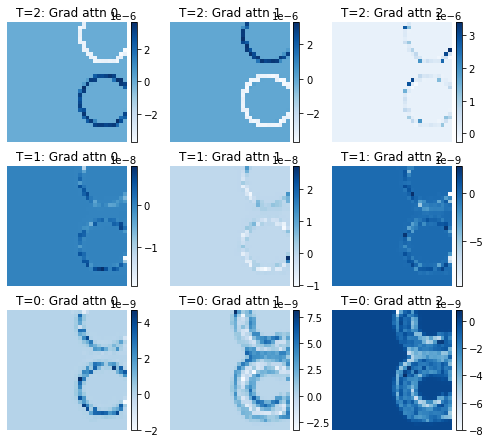

iter 2250 , loss 0.09688866 , lr 0.00013085412528623374


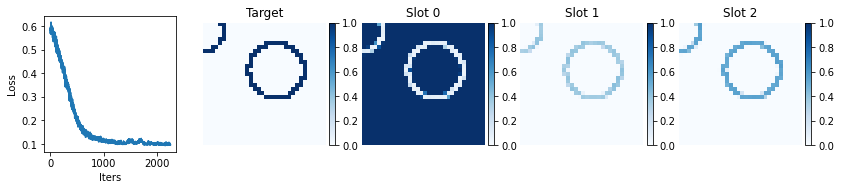

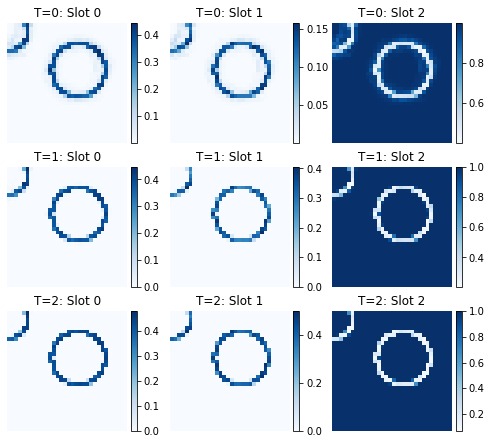

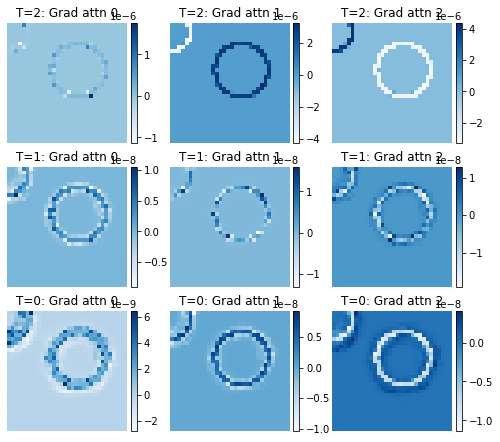

iter 2500 , loss 0.096606284 , lr 0.00014489044933872682


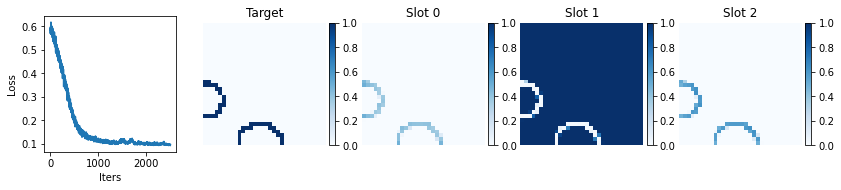

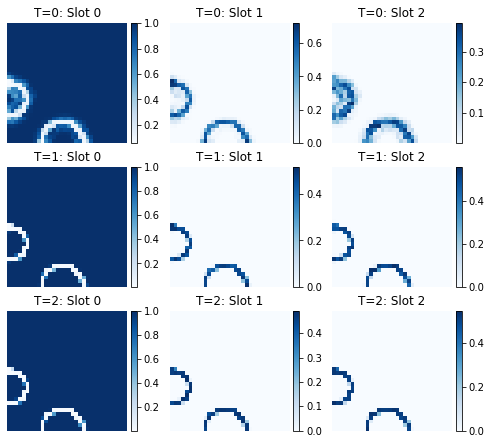

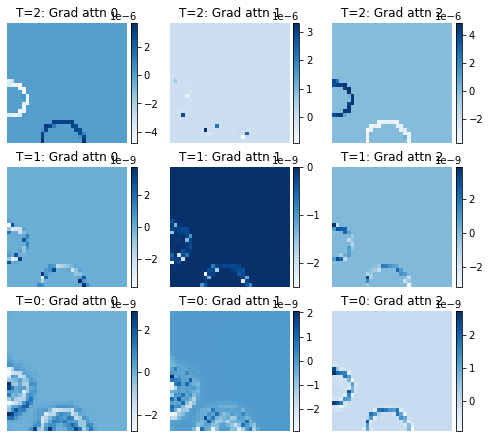

iter 2750 , loss 0.10710317 , lr 0.00015882808311178898


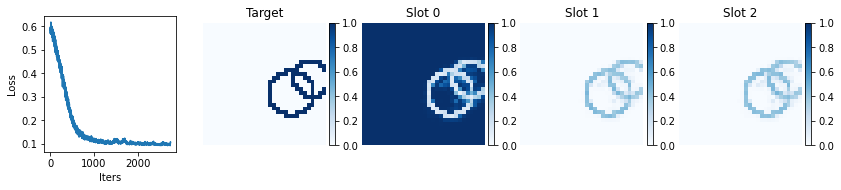

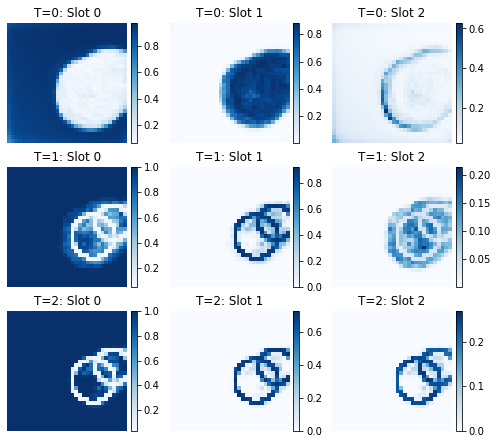

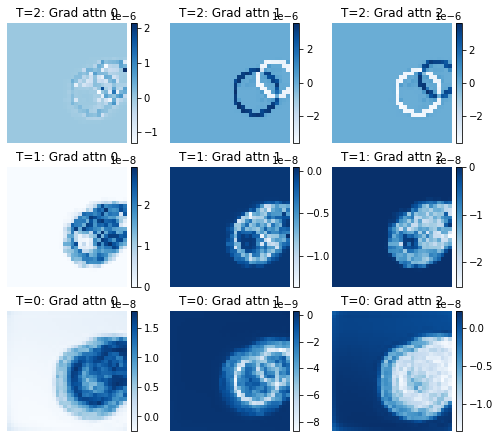

iter 3000 , loss 0.09948009 , lr 0.00017266754147854757


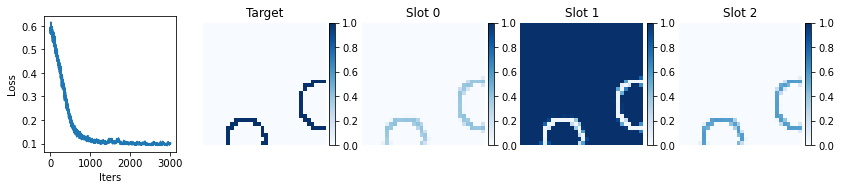

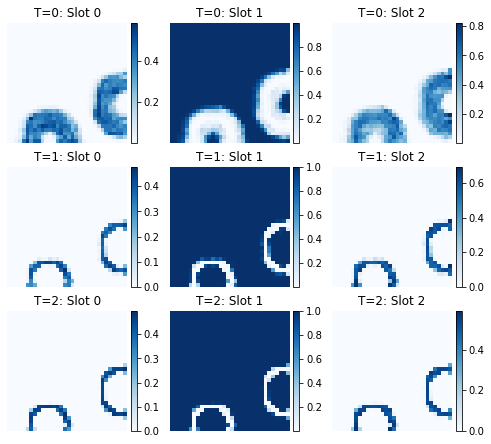

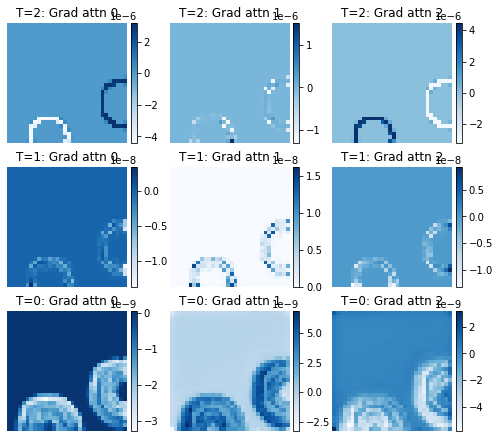

iter 3250 , loss 0.11502702 , lr 0.0001864093369307797


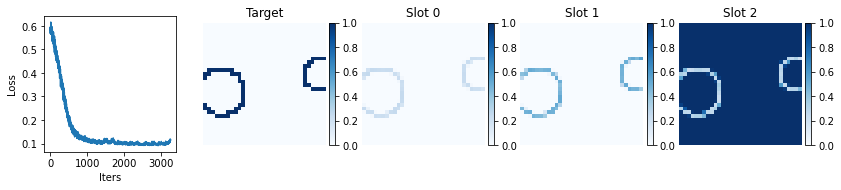

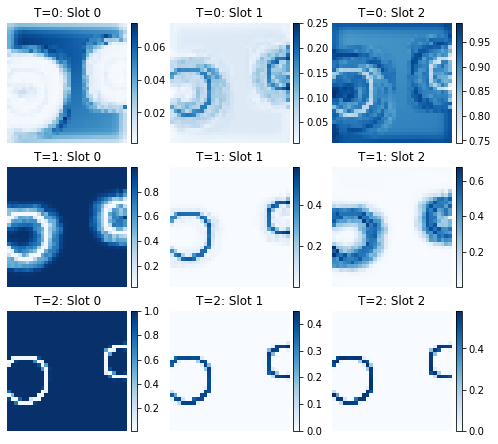

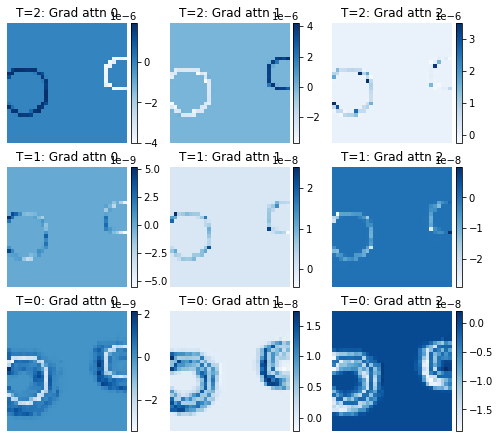

iter 3500 , loss 0.102228984 , lr 0.0002000539795892268


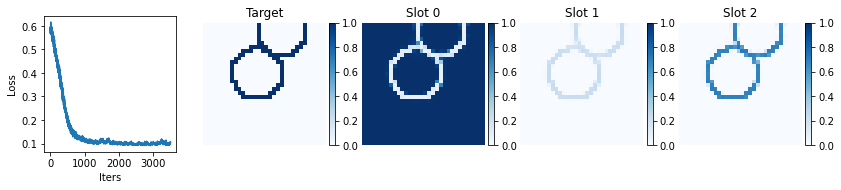

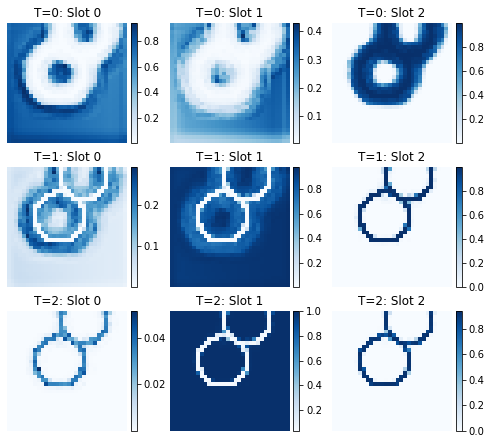

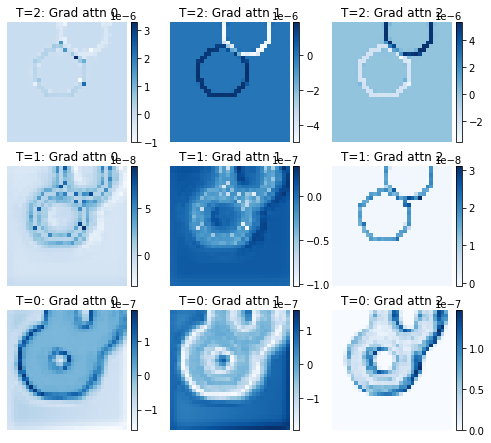

iter 3750 , loss 0.098936066 , lr 0.0002136019772138668


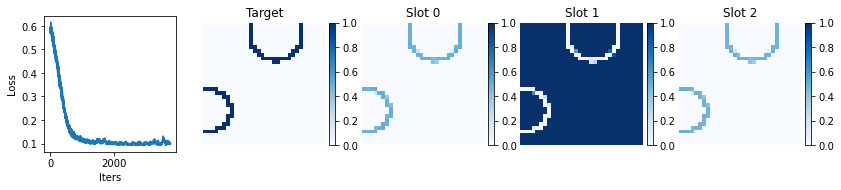

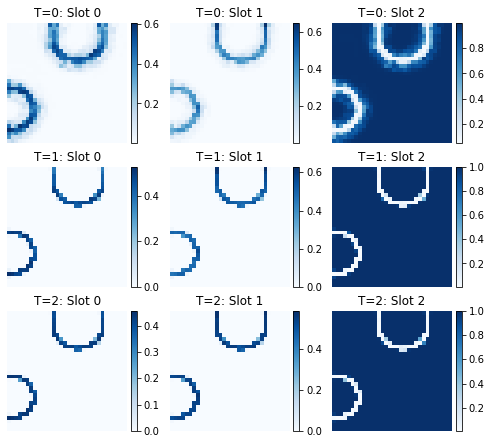

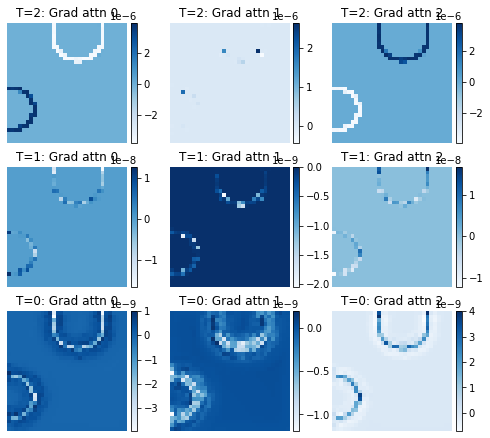

iter 4000 , loss 0.09920414 , lr 0.00022705383521414303


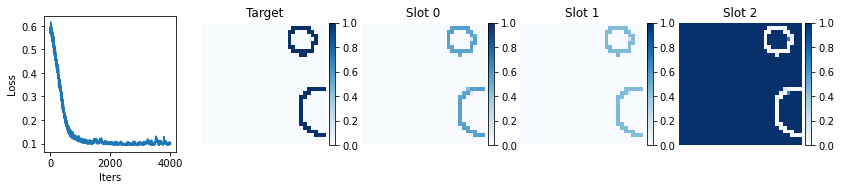

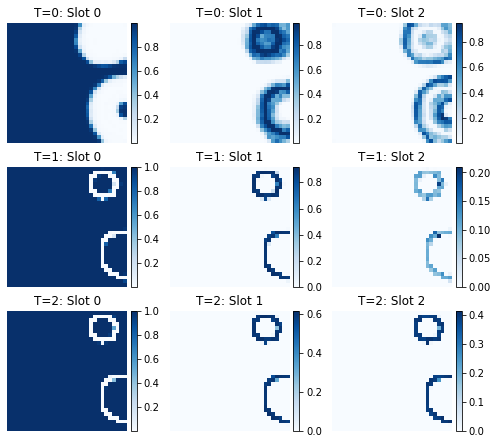

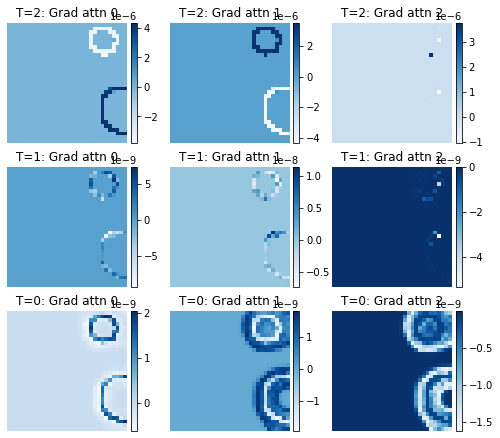

In [ ]:
bs = 256
device='cuda:0'

model,L = train(model, 40_001,bs=bs,device=device,modelDir=modelDir,figDir=figDir)